In [ ]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools

print(tf.__version__)

2.12.0


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization)

In [ ]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Data Preprocessing

In [ ]:
input_shape = (32, 32, 3)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
x_test=x_test / 255.0

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 5,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "NUM_CLASSES": 10,
    "Classes" : ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"],
}

# Custom Conv

In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

# Residual Block

In [ ]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

# Complete Network

In [ ]:
class Resnet18(Model):
  def __init__(self,):
    super(Resnet18, self).__init__(name='resnet_18')

    self.conv_1=CustomConv2D(64,7,2,padding="same")
    self.max_pool=MaxPooling2D(3,2)

    self.conv_2_1=ResidualBlock(64)
    self.conv_2_2=ResidualBlock(64)

    self.conv_3_1=ResidualBlock(128, 2)
    self.conv_3_2=ResidualBlock(128)

    self.conv_4_1=ResidualBlock(256, 2)
    self.conv_4_2=ResidualBlock(256)

    self.conv_5_1=ResidualBlock(512, 2)
    self.conv_5_2=ResidualBlock(512)

    self.global_pool=GlobalAveragePooling2D()

    self.fc_3=Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')

  def call(self, x):

    x=self.conv_1(x)

    x=self.max_pool(x)

    x=self.conv_2_1(x)
    x=self.conv_2_2(x)

    x=self.conv_3_1(x)
    x=self.conv_3_2(x)

    x=self.conv_4_1(x)
    x=self.conv_4_2(x)

    x=self.conv_5_1(x)
    x=self.conv_5_2(x)

    x=self.global_pool(x)

    return self.fc_3(x)


In [ ]:
resnet_18 = Resnet18()
resnet_18(tf.zeros([1,32,32,3]), training = False)
resnet_18.summary()

Model: "resnet_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  multiple                 9728      
 )                                                               
                                                                 
 max_pooling2d_8 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  231296    
                                                                 
 res_block (ResidualBlock)   multiple                  29

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Load and preprocess the data

# y_train = tf.squeeze(y_train)  # Remove unnecessary dimensions

# Create an instance of your ResNet-18 model
# resnet_18 = Resnet18()

# Compile the model
resnet_18.compile(optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=[SparseCategoricalAccuracy()])

# Train the model
history = resnet_18.fit(x_train, y_train,
                        batch_size=CONFIGURATION["BATCH_SIZE"],
                        epochs=CONFIGURATION["N_EPOCHS"],
                        validation_data=(x_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = resnet_18.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)






Epoch 1/5
1563/1563 [==============================] - 102s 56ms/step - loss: 1.7413 - sparse_categorical_accuracy: 0.3913 - val_loss: 1.8140 - val_sparse_categorical_accuracy: 0.3611
Epoch 2/5
1563/1563 [==============================] - 33s 21ms/step - loss: 1.3833 - sparse_categorical_accuracy: 0.5185 - val_loss: 1.5180 - val_sparse_categorical_accuracy: 0.4854
Epoch 3/5
1563/1563 [==============================] - 35s 22ms/step - loss: 1.2349 - sparse_categorical_accuracy: 0.5766 - val_loss: 1.6935 - val_sparse_categorical_accuracy: 0.4384
Epoch 4/5
1563/1563 [==============================] - 36s 23ms/step - loss: 1.0978 - sparse_categorical_accuracy: 0.6246 - val_loss: 1.0995 - val_sparse_categorical_accuracy: 0.6306
Epoch 5/5
313/313 [==============================] - 4s 11ms/step - loss: 1.0614 - sparse_categorical_accuracy: 0.6351
Test Loss: 1.0613867044448853
Test Accuracy: 0.6351000070571899


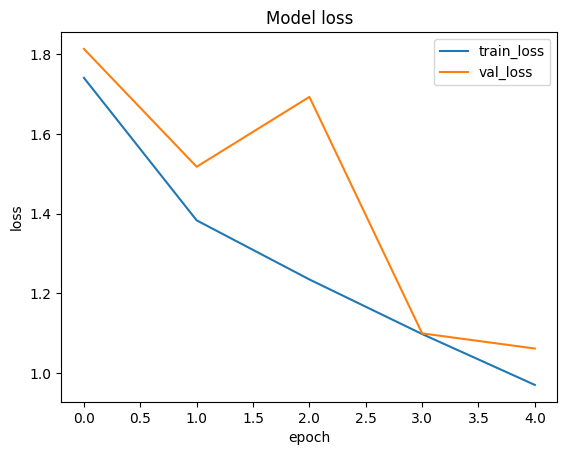

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

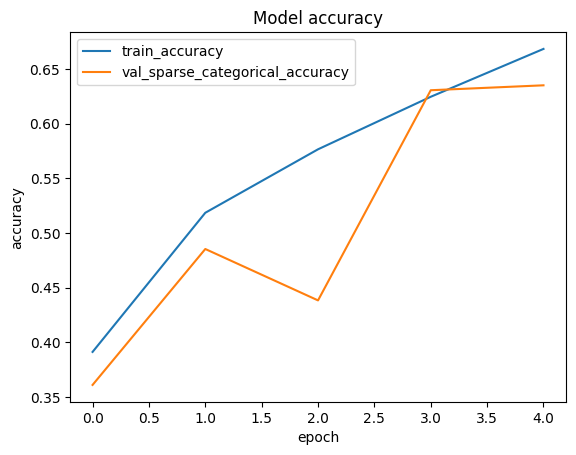

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_sparse_categorical_accuracy'])
plt.show()